In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F #Includes the activation functions
import torch.optim as optim

import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Learning Operators with PCA-Nets
Hackers: Anna Röder, Marvin Lu Hertweck
## A first easy example
We take the canonical example from last time with functions $f_i:\mathbb{R} \rightarrow \mathbb{R}$

$$ f_i(x) = p_i \sin(x) + q_i \cos(x) $$

with thier respective derivatives

$$ f'_i(x) = p_i \cos(x) - q_i \sin(x) $$

As done last time, we need to generate some functions of this type:

In [131]:
sensor_points_num = 100 #How many sensor points to consider
sensor_points = torch.linspace(0,2*math.pi,sensor_points_num) #create equidistant sensor points

def generate_random_funcs(func_num): #func_num=how many functions to generate
    p_sin = torch.randn(func_num,1) #sample from standard normal: shape (func_num,1)
    p_cos = torch.randn(func_num,1)
    f = p_sin*torch.sin(sensor_points)[None,:] + p_cos*torch.cos(sensor_points)[None,:] #[None,:] adds batch dimension -> (1,m) -> f is (func_num,m)
    return f,p_sin,p_cos

def derivative_funcs(p_sin,p_cos):
    Phi = torch.tensor([[0.0,-1.0],[1.0,0.0]]) #Known matrix for our problem
    v = torch.cat([p_sin,p_cos],dim=1).T #obtain v of shape (2, func_num)
    result = torch.matmul(Phi,v) #result (2,func_num)
    f_der = result[0][:,None]*torch.sin(sensor_points)[None,:] + result[1][:,None]*torch.cos(sensor_points)[None,:]
    return f_der,result[0][:,None],result[1][:,None]

### Generate Test data

True


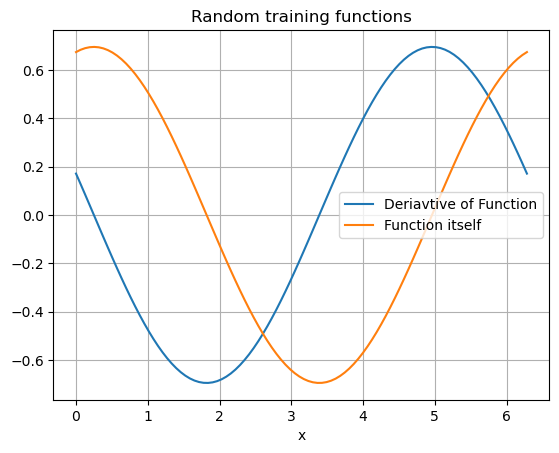

In [132]:
f,a,b = generate_random_funcs(1000)
f_der,a_der,b_der = derivative_funcs(a,b)
print(f.shape == f_der.shape)

plt.plot(sensor_points,f_der[3,:].squeeze(),label="Deriavtive of Function") #squeeze removes all dimensions from size 1
plt.plot(sensor_points,f[3,:].squeeze(),label="Function itself")
plt.grid()
plt.xlabel("x")
plt.title("Random training functions")
plt.legend()

### Generate Encoders (PCA of f and f_der)

Next we use PCA to generate the encoder and decoder. It consists of d eigenvectors $v_i$ of the covariance operator

$$ C_N = \frac{1}{N} \sum_{i=1}^d f_i \otimes f_i $$

corresponding to the largest $d$ eigenvalues $\lambda_i$. However, the scikit library takes care of this and we don't need to build $C_N$ ourselves. 

We do this for the encoder:

In [133]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(f)
basis = pca.components_.T  # Shape: (100, 10), columns are orthonormal vectors
print(pca.explained_variance_)

[5.31061894e+01 4.88476874e+01 1.16435047e-14 1.11244631e-14
 1.04318841e-14 9.58568690e-15 9.51669917e-15 8.56517993e-15
 8.50536535e-15 8.15096359e-15]


and the decoder:

In [134]:
pca2 = PCA(n_components=10)
principalComponents = pca2.fit_transform(f_der)
basis_der = pca2.components_.T  # Shape: (100, 10), columns are orthonormal vectors
print(pca2.explained_variance_)

[5.27882483e+01 4.91418947e+01 1.24271632e-14 1.21342755e-14
 1.09384951e-14 1.00584302e-14 9.58705295e-15 9.41938695e-15
 9.13583657e-15 8.33635471e-15]


### Generate test data for the underlying NN

The variable **basis** is nothing but our encoder $F_{\mathcal{X}}$ of the input space $\mathcal{X}$ and the variable **basis_der** is the encoder $F_\mathcal{Y}$ of the output space $\mathcal{Y}$

We use them to generate the transfomed data $D$ to train the NN component of our operator:
\begin{align}
    D_{\text{in}} &&= &&F_{\mathcal{X}} \circ f &&= && M_{f} \cdot M_{F_{\mathcal{X}}} \\
    D_{\text{out}} &&= &&F_{\mathcal{Y}} \circ f_{der} &&= && M_{f_{der}} \cdot M_{F_{\mathcal{Y}}}
\end{align}


In [135]:
# coefficients of input
basis_t = torch.from_numpy(basis)
basis_t = basis_t.to(dtype = torch.float32)
f_compr = f @ basis_t

# coeffictients of output
basis_der_t = torch.from_numpy(basis_der)
basis_der_t = basis_der_t.to(dtype = torch.float32)
f_der_compr = f_der @ basis_der_t

print(f_compr.shape)
print(f_der_compr.shape)

torch.Size([1000, 10])
torch.Size([1000, 10])


### Introduce the NN

In [146]:
class FiveLayerSELU(nn.Module):
    def __init__(self):
        super(FiveLayerSELU, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 20),
            nn.SELU(),
            nn.Linear(20, 30),
            nn.SELU(),
            nn.Linear(30, 10)
        )

    def forward(self, x):
        return self.net(x)

In [137]:
# Modell, Loss, Optimizer
epochs = 80000
model = FiveLayerSELU()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_all = []
for epoch in range(epochs):
    outputs = model(f_compr)
    loss = criterion(outputs, f_der_compr)
    loss_all.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if ((epoch+1)%10000 == 0):
        print(f"Epoch {epoch+1}, Loss: {loss.item():.7f}")

Epoch 10000, Loss: 0.0007114
Epoch 20000, Loss: 0.0000614
Epoch 30000, Loss: 0.0000333
Epoch 40000, Loss: 0.0000260
Epoch 50000, Loss: 0.0000221
Epoch 60000, Loss: 0.0000195
Epoch 70000, Loss: 0.0000178
Epoch 80000, Loss: 0.0000160


### Plot of the loss over all iterations

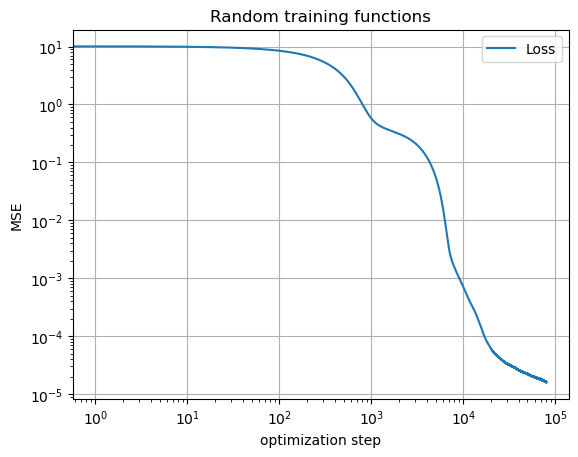

In [138]:
plt.loglog(range(epochs),loss_all,label="Loss")  
plt.grid()
plt.xlabel("optimization step")
plt.ylabel("MSE")
plt.title("Random training functions")
plt.legend()

### Build the operator

By concatination, we can build our approximation operator:

$$ \Psi_{PCA}(x) = (G_{\mathcal{Y}} \circ \varphi \circ F_{\mathcal{X}}) (x) = M_{G_{\mathcal{Y}}} \varphi( \hspace{2pt} x \hspace{2pt} M_{F_{\mathcal{X}}}) $$

tensor([ 1.0654e+01,  6.4317e+00,  1.6119e-05,  2.8399e-04,  9.5009e-06,
        -1.0395e-06, -2.9205e-07, -7.7586e-07, -6.9674e-06, -1.9245e-05],
       grad_fn=<ViewBackward0>)


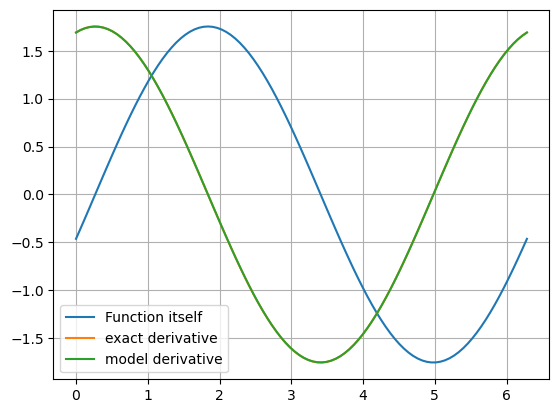

In [139]:
def psi_PCA(x):
    """
    x is an input vector
    returns the output of the approximation operator
    """
    print(model.forward(x @ basis_t))
    return model.forward(x @ basis_t) @ basis_der_t.T

# test for one of the training data examples
x = psi_PCA(f[531,:]).detach().numpy()
plt.plot(sensor_points, f[531,:].detach().numpy(), label="Function itself")
plt.plot(sensor_points, f_der[531,:].detach().numpy(), label="exact derivative")
plt.plot(sensor_points, x, label="model derivative")
plt.legend()
plt.grid()
plt.show()

### Test the code for some further functions

tensor([[ 9.2137e+00,  4.8112e+00,  1.3541e-05,  2.4178e-04,  7.7680e-06,
         -1.1396e-06, -2.4084e-07, -6.6152e-06, -3.0956e-06, -1.6102e-05]],
       grad_fn=<AddmmBackward0>)


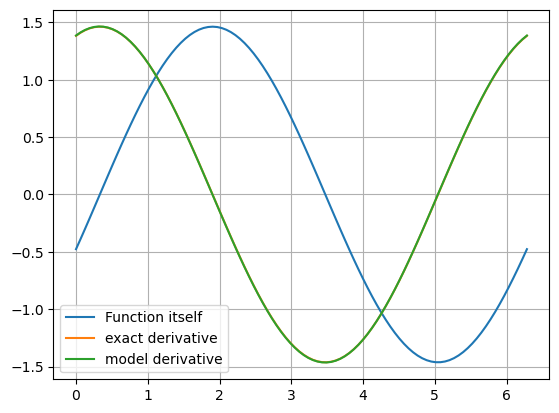

In [145]:
test_in, a, b = generate_random_funcs(1)
test_out, a, b = derivative_funcs(a, b)
test_oper = psi_PCA(test_in)

plt.plot(sensor_points, test_in.squeeze().detach().numpy(), label="Function itself")
plt.plot(sensor_points, test_out.squeeze().detach().numpy(), label="exact derivative")
plt.plot(sensor_points, test_oper.squeeze().detach().numpy(), label="model derivative")
plt.legend()
plt.grid()
plt.show()

### Print of the basis functions just out of curiosity

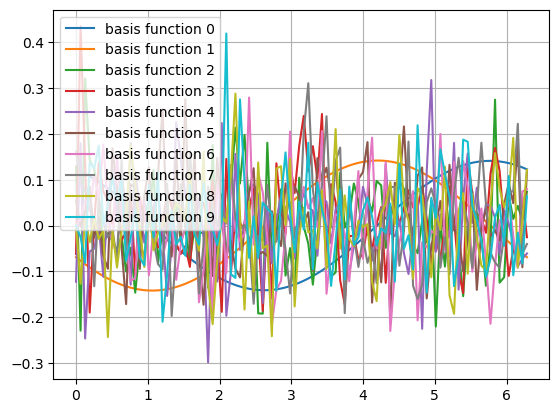

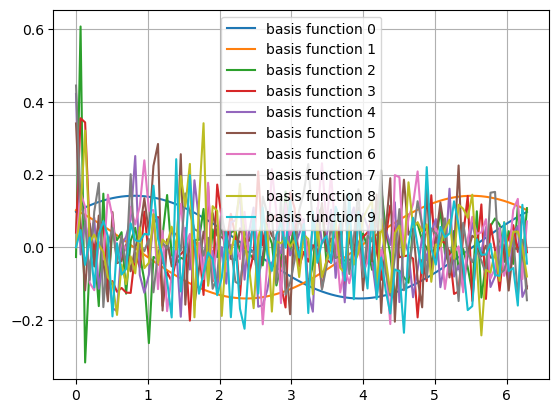

In [141]:
for i in range(10):
    plt.plot(sensor_points, basis[:,i], label=f"basis function {i}")
plt.legend()
plt.grid()
plt.show()

for i in range(10):
    plt.plot(sensor_points, basis_der[:,i], label=f"basis function {i}")
plt.legend()
plt.grid()
plt.show()